In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units
import camb
from camb import model, initialpower

In [8]:
nside = 1024; lmax = 2500

In [9]:
# power_law in uK_RJ, not uK_CMB

f1 = convert_units('uK_RJ','uK_CMB', 100)
f2 = convert_units('K_CMB','uK_RJ', 100); f4 = convert_units('K_CMB','uK_RJ', 353)
f3 = convert_units('uK_RJ', 'uK_CMB', 100)

In [10]:
ali_ma = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits', verbose=False)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

In [11]:
# I Q U
# uK_CMB
dust_95_psm = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/thermaldust_map_95GHz.fits', field = None), nside_out = 1024)
dust_150_psm = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/thermaldust_map_150GHz.fits', field = None), nside_out = 1024)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [12]:
dust_test = hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-353_2048_R3.00_full.fits', verbose=False, field = None, h = True)

In [45]:
dust_test[1]

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 24576),
 ('NAXIS2', 49152),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 3),
 ('TFORM1', '1024D'),
 ('TTYPE1', 'TEMPERATURE'),
 ('TFORM2', '1024D'),
 ('TTYPE2', 'Q_POLARISATION'),
 ('TFORM3', '1024D'),
 ('TTYPE3', 'U_POLARISATION'),
 ('EXTNAME', 'SIGNAL'),
 ('POLAR', True),
 ('POLCCONV', 'COSMO'),
 ('TUNIT1', 'K_CMB'),
 ('TUNIT2', 'K_CMB'),
 ('TUNIT3', 'K_CMB'),
 ('PIXTYPE', 'HEALPIX'),
 ('ORDERING', 'RING'),
 ('NSIDE', 2048),
 ('NPIX', 50331648),
 ('OBJECT', 'FULLSKY'),
 ('FIRSTPIX', 0),
 ('LASTPIX', 50331647),
 ('INDXSCHM', 'IMPLICIT'),
 ('GRAIN', 0),
 ('COMMENT', '        GRAIN =1: 1 pixel index for each pixel,'),
 ('COMMENT', '        GRAIN >1: 1 pixel index for Grain consecutive pixels'),
 ('BAD_DATA', -1.6375e+30),
 ('COORDSYS', 'G'),
 ('COMMENT', '        G = Galactic, E = ecliptic, C = celestial = equatorial'),
 ('COMMENT',
  ' *** PSM header ********************************************************'),
 ('COMM

In [13]:
# unit of CMB: uk_CMB; unit of noise: uK_CMB
cmb = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/cmb_maps_camb.fits', verbose=False, field=None), nside_out = 1024)


# noise_150 = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/noise_realizations_150.fits',field = None, verbose=False), nside_out = 1024)
# noise_150_ma = Mask(noise_150)

# # Q, U, spectra index
# # uK_RJ
# dust_real = hp.ud_grade(hp.read_map('/home/jianyao/Ali_maps/COM_CompMap_QU-thermaldust-commander_2048_R3.00_full.fits', verbose=False, field = None), nside_out = 1024)


#planck simulations
# I Q U
# K_CMB
dust_353 = f4*hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-353_2048_R3.00_full.fits', verbose=False, field = None), nside_out = 1024)
# dust_100 = 1e6*hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-100_2048_R3.00_full.fits', verbose=False, field = None), nside_out = 1024)

In [14]:
def Extra(nu):
    _dust_extra = np.zeros((3, 12*nside**2))
    _dust_beta = np.ones(12*nside**2)*1.54
    # dust_extra Q map
    _dust_extra[1] = f3*dust_353[1]*(nu/353)**(_dust_beta)
    # dust_extra U map 
    _dust_extra[2] = f3*dust_353[2]*(nu/353)**(_dust_beta)
    
    return _dust_extra

In [15]:
dust_extra_95 = Extra(95); dust_extra_150 = Extra(150)

In [31]:
L = lmax; Q = int(L/2); Ell = np.ones(Q)
def bin_l(cl):
    if len(cl.shape) > 2 :
        bin_averages = np.zeros((Q, cl.shape[1], cl.shape[1]))
    else:
        bin_averages = np.zeros(Q)
#     for l in range(L):
#         cl[l] = l*(l+1)/2/np.pi*(cl[l])    
    for q in range(Q):
        bin_averages[q] = (sum(cl[q*L//Q:((q+1)*L//Q)]/(L//Q)))
    return bin_averages

for i in range(0,int(Q)):
    Ell[i] = (2*i+1)*L//Q/2 

# Anisotropic and isotropic noise

In [71]:
n150cl = hp.anafast(noise_150, lmax = lmax)

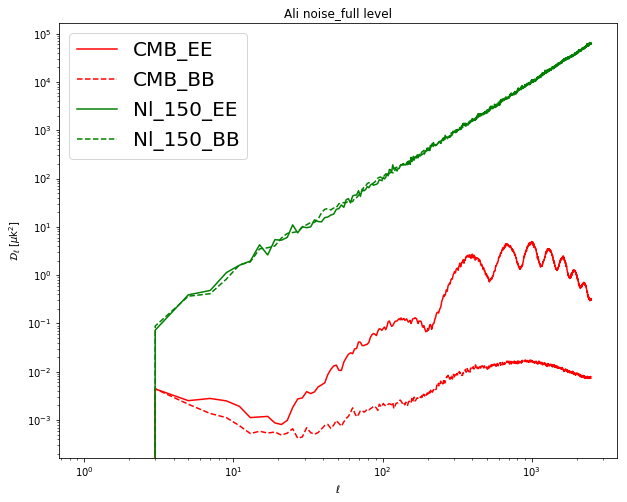

In [222]:
ell = np.arange(len(cmb_cl[0]))
plt.figure(figsize = (10,8))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[1]),'r', label = 'CMB_EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[2]),'r--', label = 'CMB_BB')
# plt.loglog(ell, ell*(ell+1)/2/np.pi*cmb_cl[2],'r--', label = 'CMB_BB')

# plt.subplot(121)
# plt.plot(ell, ell*(ell+1)/2/np.pi*ncl1, 'b-x')
# # # plt.subplot(122)
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[1]), 'k-', label = 'Nl_95_EE')
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[2]), 'k--', label = 'Nl_95_BB')

plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[1]), 'g', label = 'Nl_150_EE')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[2]), 'g--', label = 'Nl_150_BB')

plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Ali noise_full level')
plt.legend(fontsize = 20)
plt.savefig('./ps_full_area_cmb_noise.pdf', format = 'pdf')

In [213]:
white_noise = hp.read_map('/smc/jianyao/Ali_maps/full_white_noise_realization_150.fits', field = None)
wn_ma = Mask(white_noise)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [214]:
noise_150_full = hp.read_map('/smc/jianyao/Ali_maps/full_noise_realizations_150.fits',field = None, verbose=False)
noise_150_full_ma = Mask(noise_150_full)

In [215]:
#signal plus white noise
swn = cmb + white_noise
#signal plus anisotropic noise
sn = cmb + noise_150_full_ma

cmb_ma = Mask(cmb) 
sn_ma = Mask(sn) ; swn_ma = Mask(swn)

In [216]:
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)
sn_cls = hp.anafast(sn_ma, lmax = lmax, nspec = 3); 
nls = hp.anafast(noise_150_full_ma, lmax = lmax, nspec = 3)
swn_cls = hp.anafast(swn_ma, lmax = lmax, nspec = 3)
wnls = hp.anafast(wn_ma, lmax = lmax, nspec = 3)

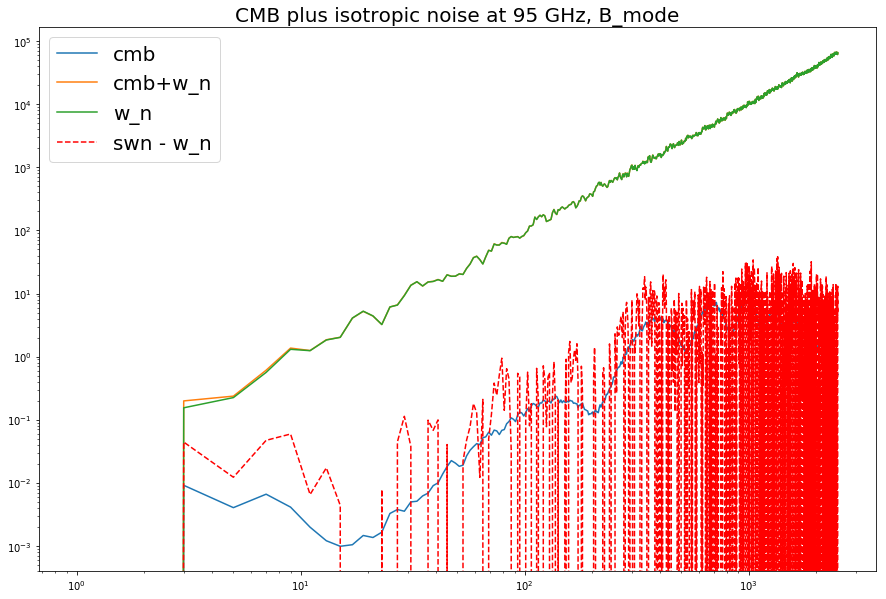

In [220]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0])); 
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), label = 'cmb')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(swn_cls[S]), label = 'cmb+w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(wnls[S]), label = 'w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'r--',label = 'swn - w_n')
plt.title('CMB plus isotropic noise at 95 GHz, B_mode', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./cmb_white_noise_95_GHz_B.pdf', format = 'pdf')

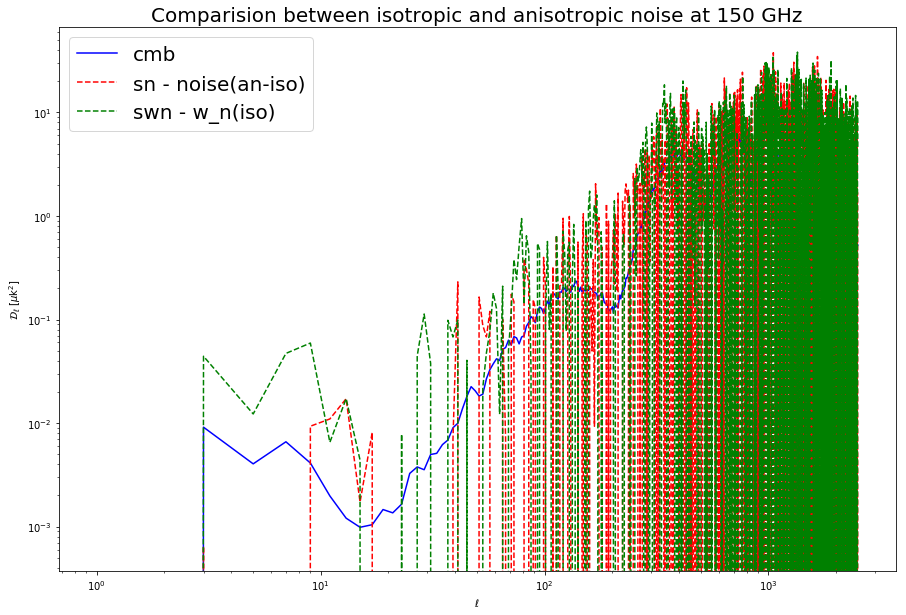

In [218]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0]))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), 'b-',label = 'cmb')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sn_cls[S]), label = 'cmb+noise')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[S]), label = 'noise')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((sn_cls[S] - nls[S])), 'r--',label = 'sn - noise(an-iso)')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'g--',label = 'swn - w_n(iso)')
plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Comparision between isotropic and anisotropic noise at 150 GHz', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./comparision_B_mode_150GHz.pdf', format = 'pdf')

In [138]:
# plt.figure(figsize = (15, 10));
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S]) - (sn_cls[S] - nls[S])), 'r--',label = 'swn - w_n')
# plt.savefig('recovery_nosie_difference_95_Bmode.pdf', format = 'pdf')

# Dealing with foreground issue

In [24]:
noise_ali = hp.read_map('/smc/jianyao/Ali_maps/noise_realizations1.fits',field = None, verbose=False)

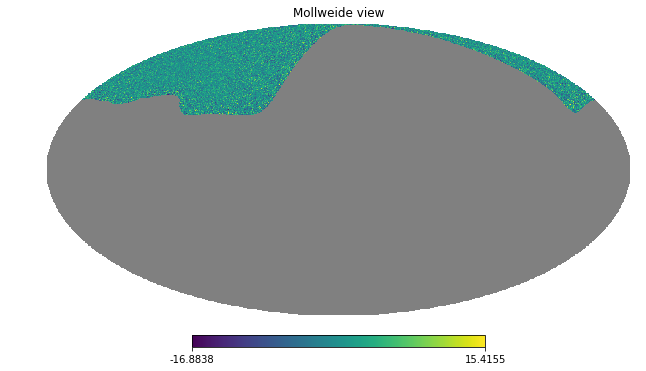

In [26]:
hp.mollview(noise_ali_ma[0])

In [25]:
noise_ali_ma = Mask(noise_ali)

In [33]:
# signal + foreground + noise
sfn = Mask(cmb + noise_ali + dust_95_psm )
sfn_cl = hp.anafast(sfn , lmax = lmax, nspec = 3)
 
#signal + foreground - extra + noise 
sn_exf = cmb + dust_95_psm - 2*dust_extra_95 + noise_ali
sn_exf_ma = Mask(sn_exf)
sn_exf_cl = hp.anafast(sn_exf_ma, lmax = lmax , nspec = 3)

In [28]:
nls = hp.anafast(noise_ali_ma, lmax = lmax, nspec = 3)

In [29]:
cmb_ma = Mask(cmb) 
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)

Text(0.5, 1.0, 'Dust')

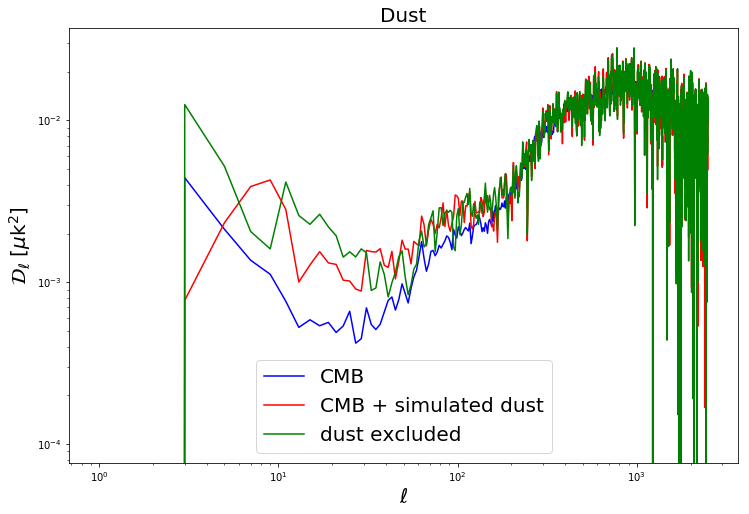

In [34]:
K = 2
ell = np.arange(len(cmb_cls[0])); #Ell = ell*(ell + 1)/2/np.pi
plt.figure(figsize = (12, 8))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[K]), 'b',label = 'CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sfn_cl[K] - nls[K]), 'r',label = 'CMB + simulated dust')

plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sn_exf_cl[K] - nls[K]),'g', label = 'dust excluded')
plt.legend(fontsize = 20)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 20)
plt.title('Dust', fontsize = 20)
# plt.savefig('../results/noise_dust.png', format = 'png')

# Apply ILC method 

In [35]:
def Power_spectrum(maps,R, lmax):
    global cl
    ''' revised for upper-triangle of the matrix '''
    n_f = len(maps)
#     print(n_f)
    cl = np.ones((n_f*n_f, lmax +1)); Cl = np.zeros((lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R)
            else:
                cross_ps = np.zeros((3, lmax+1)) ## TT, EE, BB
            cl[k] = cross_ps[2]
            k += 1
#     print(cl.shape)
    for l in range(lmax+1):
        Cl[l, 0:n_f , 0:n_f] = cl[:,l].reshape(n_f, n_f)
        Cl[l] += Cl[l].T - np.diag(Cl[l].diagonal()) 
    return Cl

In [36]:
noise_95 = hp.read_map('/smc/jianyao/Ali_maps/noise_realizations1.fits', field = None)
noise_150 = hp.read_map('/smc/jianyao/Ali_maps/noise_realizations_150.fits', field = None)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [56]:
# total power spectrum
total = np.zeros((2, 3, 12*nside**2))
total[0] = dust_95_psm + cmb + noise_95 - 10*dust_extra_95; 
total[1] = dust_150_psm + cmb + noise_150 - 10*dust_extra_150 
total_ps = Power_spectrum(Mask(total), 0, lmax = lmax)

# noise power spectrum
Noise = np.zeros((2,3,12*nside**2))
Noise[0] = noise_95;  Noise[1] = noise_150
noise_ps = Power_spectrum(Mask(Noise), 0, lmax = lmax)

In [57]:
e = np.matrix(np.ones(2))
noise_bin = bin_l(noise_ps); noise_ilc = np.zeros(Q); total_bin = bin_l(total_ps)
cl_ilc = np.zeros(Q)
#calculate the weight
W = np.matrix(np.zeros((Q, 2)))
for l in range(Q):
    norm = e*np.linalg.pinv((total_bin[l]))*e.T
    W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   
    
for i in range(Q):
    noise_ilc[i] = W[i,:]*(noise_bin[i])*np.transpose(W[i,:])
    cl_ilc[i] = 1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) - noise_ilc[i]

/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [39]:
cmb_ma = Mask(cmb) 
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)

In [40]:
cls = bin_l(cmb_cls[2])

In [41]:
total_ps_95 = hp.anafast(Mask(total[0]), lmax = lmax, nspec = 3); nl_95 = hp.anafast(Mask(noise_95), lmax = lmax, nspec = 3)

In [42]:
cl_extra = bin_l(total_ps_95[2] - nl_95[2])

Text(0.5, 1.0, 'ILC recovery, subtracting 10*dust')

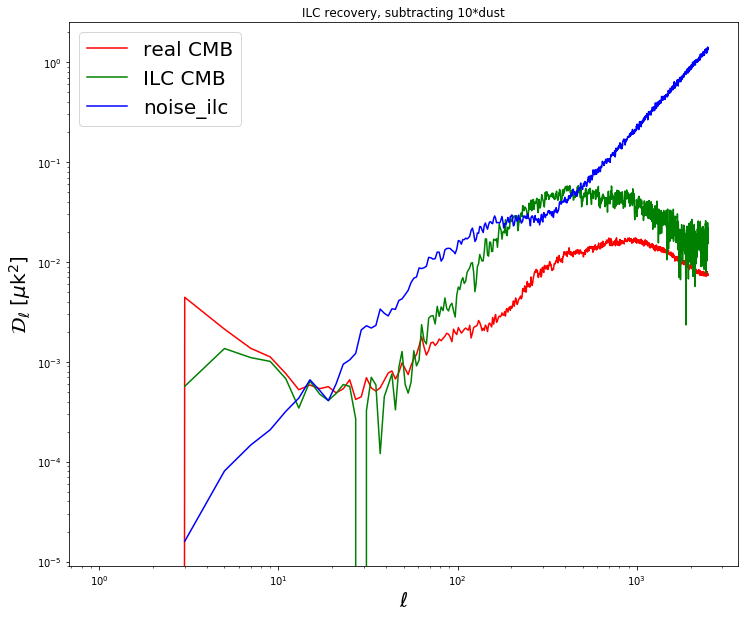

In [59]:
plt.figure(figsize = (12, 10))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cls, 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_ilc, 'g-', label = 'ILC CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b-', label = 'noise_ilc')

# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_extra, 'b-',label = 'extra CMB')

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 20)
plt.legend(fontsize = 20)
plt.title('ILC recovery, subtracting 10*dust')
# plt.ylim(4e-5, 4e-2)
# plt.savefig('../results/ILC_before_extra_no_comparision.pdf', format = 'pdf')

# CAMB CMB cls

In [39]:
pars = camb.CAMBparams(); pars.WantTensors = True
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r=0.05)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)

In [31]:
1.881*1e-9/np.e**(-2*0.078)

2.1985620880120438e-09

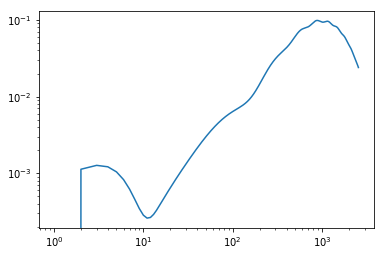

In [40]:
total = np.transpose(powers['total'])
lmax = 2550
ell = np.arange(lmax + 1)
plt.loglog(ell, (ell*(ell+1))/2/np.pi*total[2])

In [41]:
np.savetxt('./cls_r_0p05.txt', total)

In [136]:
cmb_maps = hp.synfast(total, nside = 1024, new = True)
hp.write_map('/smc/jianyao/Ali_maps/cmb_maps_camb.fits', cmb_maps)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


# pysm simulation 

In [169]:
# #

nu = np.array([100, 150, 353]);nside = 1024;
coefficients = convert_units("uK_RJ", "uK_CMB", nu)

def convert_unit(map):
    Nf = len(nu)
    for i in range(0,Nf):
        map[i] = map[i]*coefficients[i]
    return map

sky_config = {'dust':models('d1', nside)}
sky = pysm.Sky(sky_config)

dust_pysm = convert_unit(sky.signal()(nu))

# uK_CMB

15008.372537735582

# Ali noise and mask

In [11]:
# calculate the f_sky 
noise_ali = hp.read_map('/smc/jianyao/Ali_maps/noise_realizations1.fits', h = True)
n = (noise_ali[0]*0 + 1)
f_sky = len(n[n==1])/(12.0*nside**2)
# # nl_ful 

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [12]:
f_sky

1.0

In [99]:
### To generate the Ali_observational mask, and mask out the edge parts (I > 5 uK_CMB ) which have large errors.
n2test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_95_G_1024.fits', partial=True)
n2zeros = n2test*0
n2 = np.zeros_like(n2test);
index = np.arange(len(n2test))
n2[n2test <= 5] = 1
# ali_mask = hp.write_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits', n2)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/jianyao/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [100]:
## To generate one realization of noise maps. 

n3test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_150_G_1024.fits', partial=True)
nIQU = np.zeros((3, len(n3test)))
index = np.arange(len(n2test))#index[n2zeros == 0]
for i in index[n2test <= 5]:
    nIQU[0][i] = np.random.normal(0, n3test[i])
    nIQU[1][i] = np.random.normal(0, n3test[i]*np.sqrt(2))
    nIQU[2][i] = np.random.normal(0, n3test[i]*np.sqrt(2))

# hp.write_map('/smc/jianyao/Ali_maps/noise_realizations_150.fits', nIQU)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


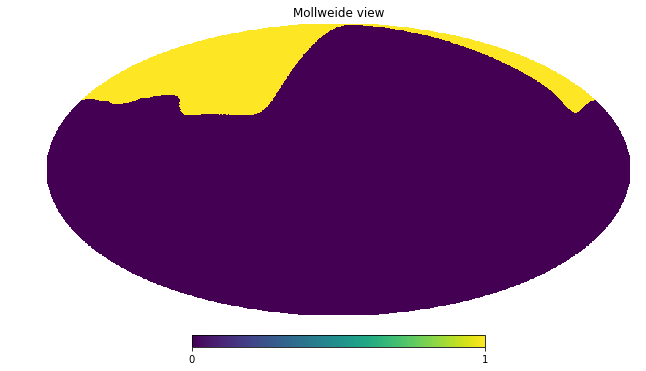

In [107]:
hp.mollview(ali_ma)

In [119]:
noise_ali = hp.read_map('/smc/jianyao/Ali_maps/noise_realizations1.fits',field = None, verbose=False)
noise_ali_ma = Mask(noise_ali)
f_sky = np.sum(ali_ma)/(12*nside**2) # f_sky = 0.1120
nl_full = hp.anafast(noise_ali_ma)/f_sky;
wn = hp.synfast(nl_full, nside = nside, new = True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [120]:
f_sky

0.1120460828145345

In [121]:
hp.write_map('/smc/jianyao/Ali_maps/white_noise_realization_95.fits', wn)